# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from art.utils import load_cifar10
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.defences.trainer import AdversarialTrainerMadryPGD

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

In [13]:
num_samples = 10000
sample_idx = np.random.choice(x_train.shape[0], num_samples)

In [14]:
x_train = x_train[sample_idx]
y_train = y_train[sample_idx]

# Proxy Model

In [15]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10)
    ])
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [16]:
model = create_model()

In [17]:
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(32, 32, 3),
    loss_object=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam()
)

In [22]:
proxy = AdversarialTrainerMadryPGD(
    classifier=classifier,
    nb_epochs=10,
    eps=0.15,
    eps_step=0.001
)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

# Attack

In [23]:
y_target = np.zeros(10, dtype=np.float32)
y_target[4] = 1.0
y_target

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [24]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)

In [25]:
attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor,
    proxy_classifier=proxy.get_classifier(),
    target=y_target,
    pp_poison=0.3,
    norm=2,
    eps=5,
    eps_step=0.1,
    max_iter=200
)

In [26]:
poison_data, poison_labels = attack.poison(x_train, y_train)

PGD - Batches: 0it [00:00, ?it/s]

In [31]:
classifier.fit(poison_data, poison_labels, nb_epochs=10)

# Results

In [52]:
not_target = np.logical_not(np.all(y_test == y_target, axis=1)).astype(int)

In [59]:
poisoned_x_test, poisoned_y_test = backdoor.poison(x_test[not_target], y_test[not_target])

In [60]:
poison_preds = np.argmax(classifier.predict(poisoned_x_test), axis=1)
poison_preds

array([4, 4, 4, ..., 4, 4, 4])

In [61]:
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))

In [64]:
print("Poisoned Set Accuracy:", poison_correct / len(poison_preds))

Poisoned Set Accuracy: 0.0


In [69]:
y_true = np.argmax(y_test[not_target], axis=1)

In [72]:
cifar10_class_labels = ["airplane", "automobile", "bird", "cat", "deer",
                        "dog", "frog", "horse", "ship", "truck"]

Target: deer


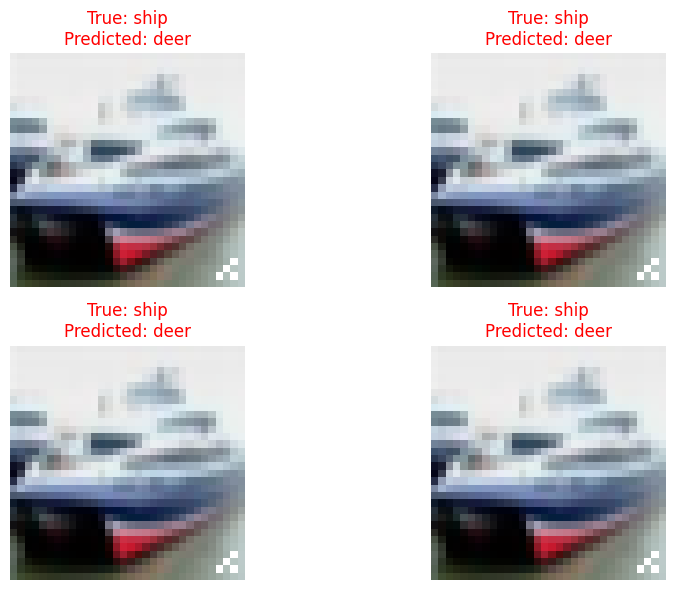

In [75]:
print("Target:", cifar10_class_labels[np.argmax(y_target, axis=0)])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
random_index = np.random.randint(0, len(poisoned_x_test), 4)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(poisoned_x_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_true[random_index[i]] == poison_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {cifar10_class_labels[y_true[random_index[i]]]}\nPredicted: {cifar10_class_labels[poison_preds[random_index[i]]]}',
        color=color
    )

plt.tight_layout()
plt.show()